# C_b_1 : Recherche de modèles


In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import locale
import calendar
import holidays
from datetime import date
from references import *
from src import *

import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

import warnings

warnings.filterwarnings("ignore")
plt.style.use("fivethirtyeight")
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)

locale.setlocale(locale.LC_ALL, "fr_CA.UTF-8")

'fr_CA.UTF-8'

In [25]:
%load_ext jupyter_black

# import black
# import jupyter_black

# jupyter_black.load(
#     lab=True,
#     line_length=55,
#     target_version=black.TargetVersion.PY311,
# )

## XGBoost

https://en.wikipedia.org/wiki/XGBoost

XGBoost, which stands for Extreme Gradient Boosting, is a scalable, distributed gradient-boosted decision tree (GBDT) machine learning library. It provides parallel tree boosting and is the leading machine learning library for regression, classification, and ranking problems.

> XGBoost gained significant favor in the last few years as a result of helping individuals and teams win virtually every Kaggle structured data competition. In these competitions, companies and researchers post data after which statisticians and data miners compete to produce the best models for predicting and describing the data. (https://www.nvidia.com/en-us/glossary/data-science/xgboost/)

### Exemple inspirant ce sujet

Part 1 : https://youtu.be/vV12dGe_Fho?si=Zifv1O512VNiqJ8W  

---

### Import des données et création des features

Nous utilisons les features sans valeurs catégoriques, ce qui cause des problèmes au modèle plus loin. 

In [2]:
df = import_and_create_features_no_categorical().dropna()

---

### Séparation des données d'entraînement et de test

Séparons les données en ensemble d'entraînement et ensemble de test, où la dernière année complète (2022) servire de test.

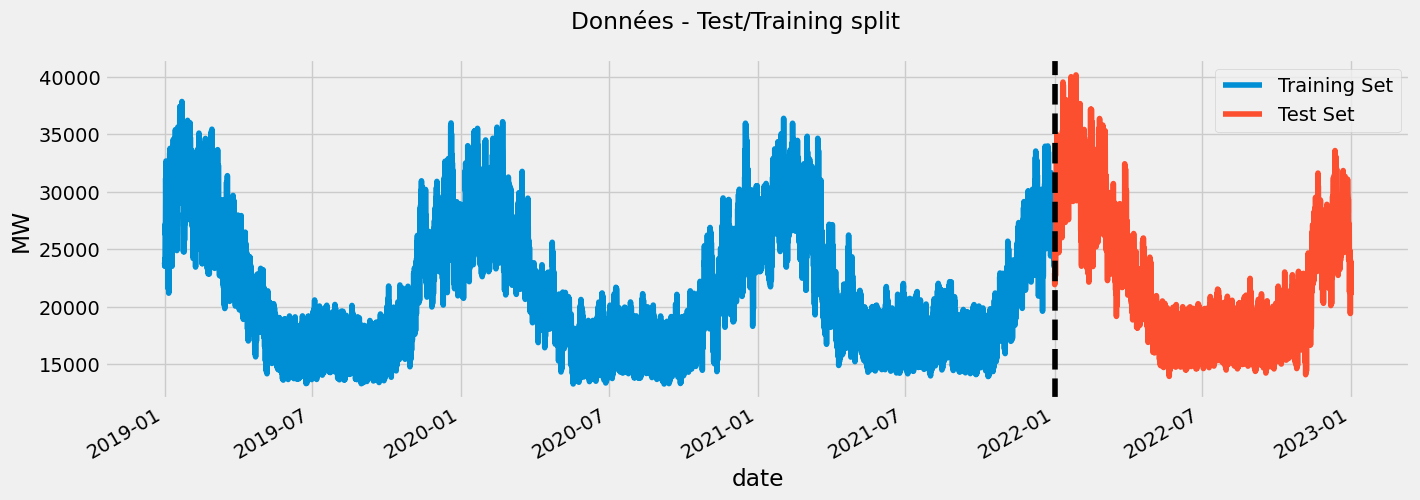

In [22]:
date_slit ='2022-01-01'

train = df.iloc[df.index < date_slit]
test = df.iloc[df.index >= date_slit]

fig, ax = plt.subplots(figsize = (15,5))
train['MW'].plot(ax=ax, label ='Training set', ylabel='MW')
test['MW'].plot(ax=ax, label ='Test set')
ax.legend(['Training Set','Test Set'])
ax.axvline(date_slit, color = 'black', ls = '--')
fig.suptitle('Données - Test/Training split')
plt.show()

In [4]:
df.head()

,MW,Temp,hourofday,quarter,year,dayofyear,dayofmonth,weekofyear,month,dayofweek,season,isWeekend,isHoliday,day_sin,day_cos,year_sin,year_cos,CDD_21,HDD_18,CDD_24,HDD_16,DT_18-21,DT_16-24,DT_18,DT_21,Temp_LAG_t-1h,DT_18-21_LAG_t-1h,DT_16-24_LAG_t-1h,DT_18_LAG_t-1h,DT_21_LAG_t-1h,Temp_LAG_t-2h,DT_18-21_LAG_t-2h,DT_16-24_LAG_t-2h,DT_18_LAG_t-2h,DT_21_LAG_t-2h,Temp_LAG_t-3h,DT_18-21_LAG_t-3h,DT_16-24_LAG_t-3h,DT_18_LAG_t-3h,DT_21_LAG_t-3h,Temp_LAG_t-4h,DT_18-21_LAG_t-4h,DT_16-24_LAG_t-4h,DT_18_LAG_t-4h,DT_21_LAG_t-4h,Temp_LAG_t-6h,DT_18-21_LAG_t-6h,DT_16-24_LAG_t-6h,DT_18_LAG_t-6h,DT_21_LAG_t-6h,Temp_LAG_t-24h,DT_18-21_LAG_t-24h,DT_16-24_LAG_t-24h,DT_18_LAG_t-24h,DT_21_LAG_t-24h,Temp_MOYMOBILE_t-1h,DT_18-21_MOYMOBILE_t-1h,DT_16-24_MOYMOBILE_t-1h,DT_18_MOYMOBILE_t-1h,DT_21_MOYMOBILE_t-1h,Temp_MOYMOBILE_t-2h,DT_18-21_MOYMOBILE_t-2h,DT_16-24_MOYMOBILE_t-2h,DT_18_MOYMOBILE_t-2h,DT_21_MOYMOBILE_t-2h,Temp_MOYMOBILE_t-3h,DT_18-21_MOYMOBILE_t-3h,DT_16-24_MOYMOBILE_t-3h,DT_18_MOYMOBILE_t-3h,DT_21_MOYMOBILE_t-3h,Temp_MOYMOBILE_t-4h,DT_18-21_MOYMOBILE_t-4h,DT_16-24_MOYMOBILE_t-4h,DT_18_MOYMOBILE_t-4h,DT_21_MOYMOBILE_t-4h,Temp_MOYMOBILE_t-6h,DT_18-21_MOYMOBILE_t-6h,DT_16-24_MOYMOBILE_t-6h,DT_18_MOYMOBILE_t-6h,DT_21_MOYMOBILE_t-6h,Temp_MOYMOBILE_t-24h,DT_18-21_MOYMOBILE_t-24h,DT_16-24_MOYMOBILE_t-24h,DT_18_MOYMOBILE_t-24h,DT_21_MOYMOBILE_t-24h
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 01:00:00,23762.55,0.0,1,1,2019,1,1,1,1,1,4,0,1,0.258819,0.965926,0.002738,0.999996,0.0,18.0,0.0,16.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-0.6,18.6,16.6,18.6,21.6,-1.5,19.5,17.5,19.5,22.5,-2.6,20.6,18.6,20.6,23.6,-9.9,27.9,25.9,27.9,30.9,0.0,18.0,16.0,18.0,21.0,0.00,18.00,16.00,18.00,21.00,-0.033333,18.033333,16.033333,18.033333,21.033333,-0.175,18.175,16.175,18.175,21.175,-0.750000,18.750000,16.750000,18.750000,21.750000,-4.795833,22.795833,20.795833,22.795833,25.795833
2019-01-01 02:00:00,23830.23,-0.2,2,1,2019,1,1,1,1,1,4,0,1,0.500000,0.866025,0.003455,0.999994,0.0,18.2,0.0,16.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-0.6,18.6,16.6,18.6,21.6,-2.3,20.3,18.3,20.3,23.3,-10.5,28.5,26.5,28.5,31.5,-0.2,18.2,16.2,18.2,21.2,-0.10,18.10,16.10,18.10,21.10,-0.066667,18.066667,16.066667,18.066667,21.066667,-0.075,18.075,16.075,18.075,21.075,-0.400000,18.400000,16.400000,18.400000,21.400000,-4.366667,22.366667,20.366667,22.366667,25.366667
2019-01-01 03:00:00,23608.07,-0.5,3,1,2019,1,1,1,1,1,4,0,1,0.707107,0.707107,0.004172,0.999991,0.0,18.5,0.0,16.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-1.5,19.5,17.5,19.5,22.5,-10.5,28.5,26.5,28.5,31.5,-0.5,18.5,16.5,18.5,21.5,-0.35,18.35,16.35,18.35,21.35,-0.233333,18.233333,16.233333,18.233333,21.233333,-0.175,18.175,16.175,18.175,21.175,-0.233333,18.233333,16.233333,18.233333,21.233333,-3.950000,21.950000,19.950000,21.950000,24.950000
2019-01-01 04:00:00,23562.48,-1.0,4,1,2019,1,1,1,1,1,4,0,1,0.866025,0.500000,0.004888,0.999988,0.0,19.0,0.0,17.0,19.0,17.0,19.0,22.0,-0.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,0.0,18.0,16.0,18.0,21.0,-0.6,18.6,16.6,18.6,21.6,-10.9,28.9,26.9,28.9,31.9,-1.0,19.0,17.0,19.0,22.0,-0.75,18.75,16.75,18.75,21.75,-0.566667,18.566667,16.566667,18.566667,21.566667,-0.425,18.425,16.425,18.425,21.425,-0.300000,18.300000,16.300000,18.300000,21.300000,-3.537500,21.537500,19.537500,21.537500,24.537500
2019-01-01 05:00:00,23546.16,-1.1,5,1,2019,1,1,1,1,1,4,0,1,0.965926,0.258819,0.005605,0.999984,0.0,19.1,0.0,17.1,19.1,17.1,19.1,22.1,-1.0,19.0,17.0,19.0,22.0,-0.5,18.5,16.5,18.5,21.5,-0.2,18.2,16.2,18.2,21.2,0.0,18.0,16.0,18.0,21.0,-0.1,18.1,16.1,18.1,21.1,-11.4,29.4,27.4,29.4,32.4,-1.1,19.1,17.1,19.1,22.1,-1.05,19.05,17.05,19.05,22.05,-0.866667,18.866667,16.866667,18.866667,21.866667,-0.700,18.700,16.700,18.700,21.700,-0.466667,18.466667,16.466667,18.466667,21.466667,-3.

### Création du modèle

In [13]:
df.columns

Index(['MW', 'Temp', 'hourofday', 'quarter', 'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'month', 'dayofweek', 'season', 'isWeekend', 'isHoliday', 'day_sin', 'day_cos', 'year_sin', 'year_cos', 'CDD_21', 'HDD_18', 'CDD_24', 'HDD_16', 'DT_18-21', 'DT_16-24', 'DT_18', 'DT_21', 'Temp_LAG_t-1h', 'DT_18-21_LAG_t-1h', 'DT_16-24_LAG_t-1h', 'DT_18_LAG_t-1h', 'DT_21_LAG_t-1h', 'Temp_LAG_t-2h', 'DT_18-21_LAG_t-2h', 'DT_16-24_LAG_t-2h', 'DT_18_LAG_t-2h', 'DT_21_LAG_t-2h', 'Temp_LAG_t-3h', 'DT_18-21_LAG_t-3h', 'DT_16-24_LAG_t-3h', 'DT_18_LAG_t-3h', 'DT_21_LAG_t-3h', 'Temp_LAG_t-4h', 'DT_18-21_LAG_t-4h', 'DT_16-24_LAG_t-4h', 'DT_18_LAG_t-4h', 'DT_21_LAG_t-4h', 'Temp_LAG_t-6h', 'DT_18-21_LAG_t-6h', 'DT_16-24_LAG_t-6h', 'DT_18_LAG_t-6h', 'DT_21_LAG_t-6h', 'Temp_LAG_t-24h', 'DT_18-21_LAG_t-24h', 'DT_16-24_LAG_t-24h', 'DT_18_LAG_t-24h', 'DT_21_LAG_t-24h', 'Temp_MOYMOBILE_t-1h', 'DT_18-21_MOYMOBILE_t-1h', 'DT_16-24_MOYMOBILE_t-1h', 'DT_18_MOYMOBILE_t-1h', 'DT_21_MOYMOBILE_t-1h',
       'Temp_MOYMOBI

Sélection de certaines features seulement pour débuter avec un modèle simple.

In [172]:
FEATURES = ["Temp", "hourofday", "dayofyear", "weekofyear", "season", "month", "DT_18"]

TARGET = "MW"

In [173]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [177]:
n_estim = 2000  # nb trees

reg = xgb.XGBRegressor(
    n_estimators=n_estim, early_stopping_rounds=50, learning_rate=0.01
)

reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100)

[0]	validation_0-rmse:21674.01427	validation_1-rmse:22647.83498
[100]	validation_0-rmse:8034.79466	validation_1-rmse:8999.61141
[200]	validation_0-rmse:3125.22792	validation_1-rmse:4069.04895
[300]	validation_0-rmse:1495.89873	validation_1-rmse:2368.65531
[400]	validation_0-rmse:1057.38956	validation_1-rmse:1836.10044
[500]	validation_0-rmse:954.31266	validation_1-rmse:1660.22385
[600]	validation_0-rmse:923.92462	validation_1-rmse:1598.61130
[700]	validation_0-rmse:907.35117	validation_1-rmse:1579.94158
[800]	validation_0-rmse:891.96170	validation_1-rmse:1576.19202
[875]	validation_0-rmse:881.78055	validation_1-rmse:1577.17709


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=2000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [194]:
print(f"Le meilleur RMSE sur les données d'entraînement est : {reg.best_score:0.2f}")

Le meilleur RMSE sur les données d'entraînement est : 1576.00


Pour référence, nous avions un RMSE de 2399 sur la régression simple (Notebook B_c_3_Test_Statistique)

### Importance des Features

Importance relative des différents features. 

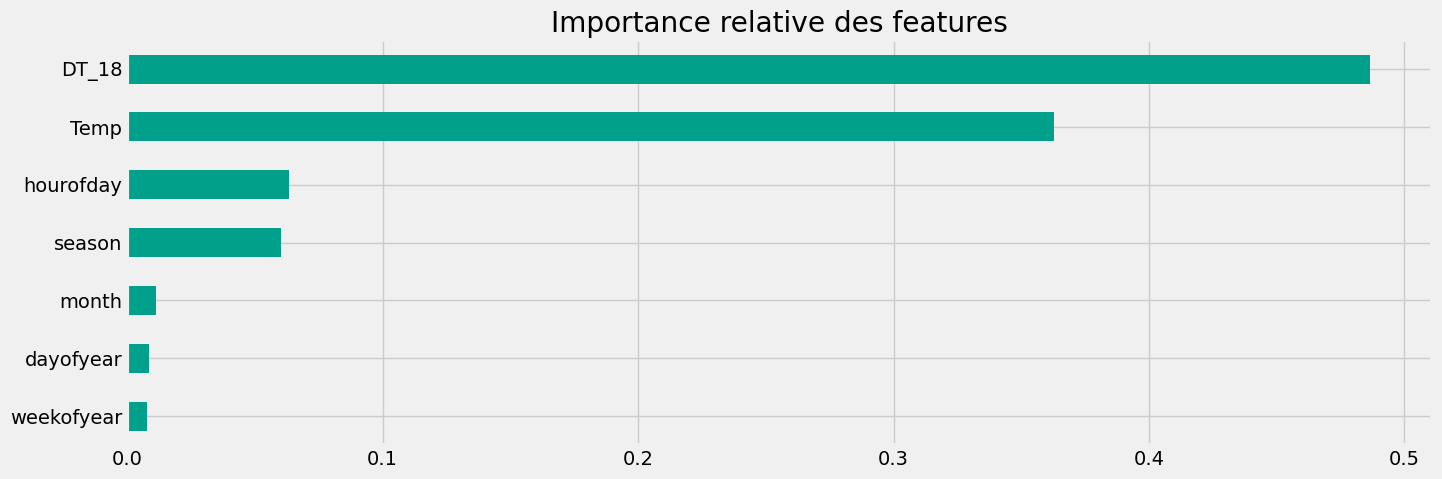

In [195]:
fi = pd.DataFrame(
    data=reg.feature_importances_, index=reg.feature_names_in_, columns=["Importance"]
)

fi.sort_values("Importance").plot(
    figsize=(15, 5),
    kind="barh",
    title="Importance relative des features",
    legend=False,
    color=colors_pal[1],
)
plt.show()

In [184]:
ratio = (
    fi.loc[fi.index == "DT_18"]["Importance"][0]
    / fi.loc[fi.index == "Temp"]["Importance"][0]
)
print(
    f"Le ratio d'importance entre le DeltaT et la température en tant que telle est de {ratio:0.2f}, ce qui indique son importance relative, donc son degré de potentiel de prévision un par rapport à l'autre. "
)

Le ratio d'importance entre le DeltaT et la température en tant que telle est de 1.34, ce qui indique son importance relative, donc son degré de potentiel de prévision un par rapport à l'autre. 


Aussi, les variables de température sont beaucoup plus importantes que les autres variables basées sur les temps et dates, ce que nous pouvions supposer avec l'évaluation statistique précédente. 

### Prédiction

In [185]:
test["prediction"] = reg.predict(X_test)

df_pred = df.merge(test[["prediction"]], how="left", left_index=True, right_index=True)

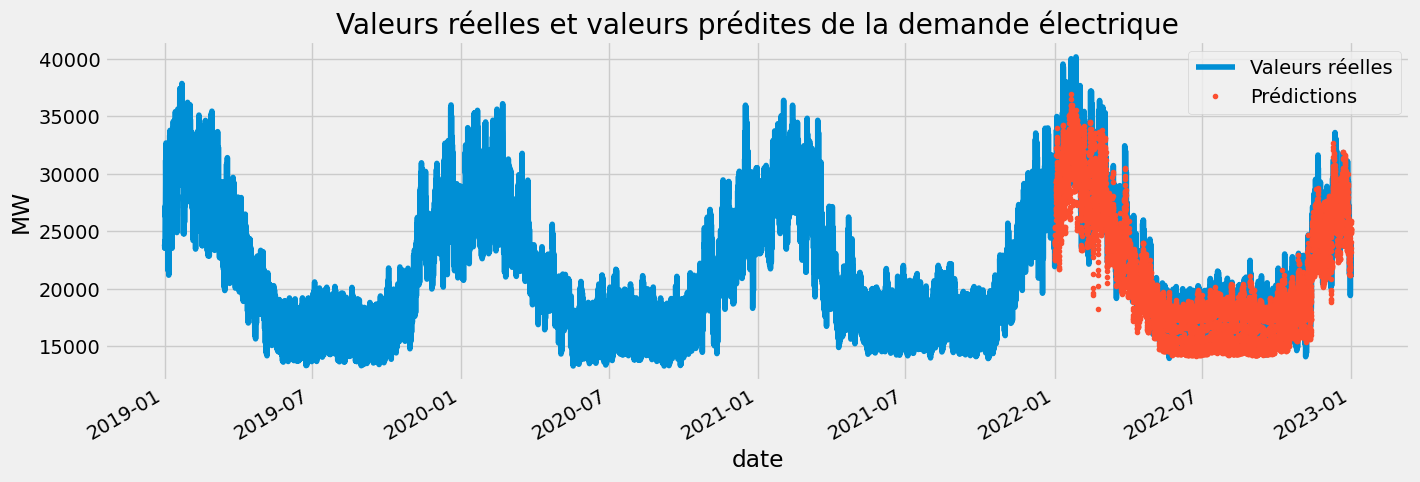

In [186]:
ax = df_pred.MW.plot(figsize=(15, 5), ylabel="MW")
df_pred.prediction.plot(ax=ax, style=".")
plt.legend(["Valeurs réelles", "Prédictions"])
ax.set_title("Valeurs réelles et valeurs prédites de la demande électrique")

plt.show()

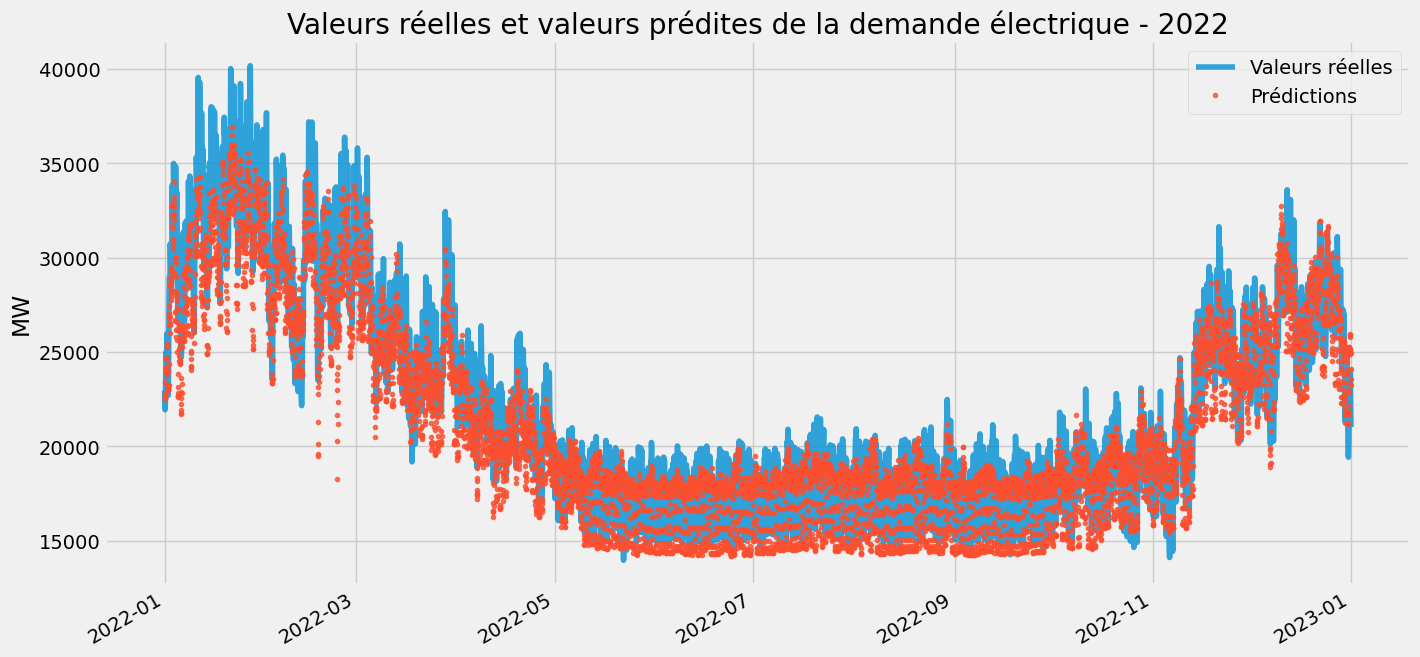

In [187]:
df_2022 = df_pred["20220101":"20221231"]

ax = df_2022.MW.plot(figsize=(15, 8), ylabel="MW", alpha=0.8)
df_2022.prediction.plot(ax=ax, style=".", alpha=0.8, xlabel="")
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title("Valeurs réelles et valeurs prédites de la demande électrique - 2022")

plt.show()

Nous pouvons voir que les journées extrêmes semblent être sous-estimées, par exemple en février 2022. 

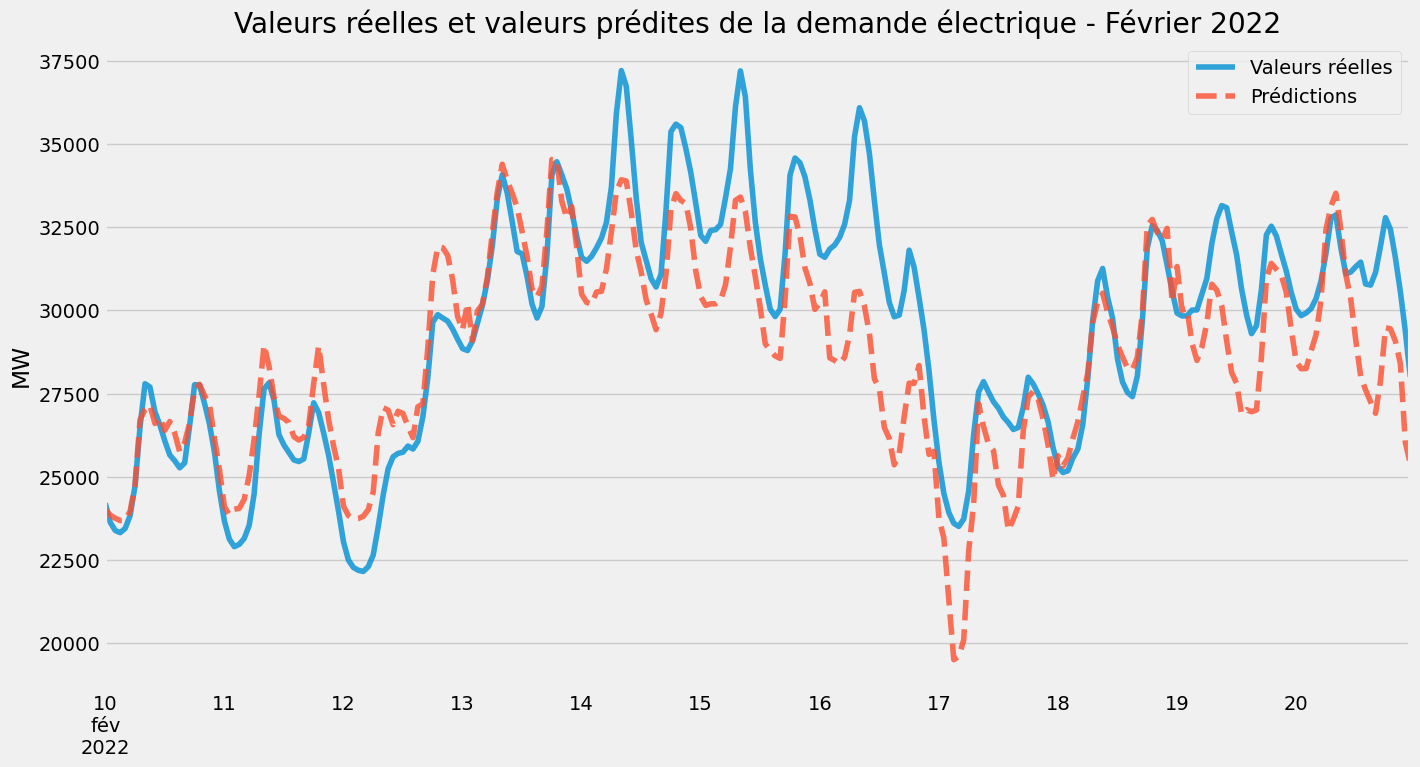

In [189]:
df_fev_2022 = df_pred["20220210":"20220220"]

ax = df_fev_2022.MW.plot(figsize=(15, 8), ylabel="MW", alpha=0.8)
df_fev_2022.prediction.plot(ax=ax, style="--", alpha=0.8, xlabel="")
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - Février 2022"
)

plt.show()

Nous pouvons clairement voir les tendances des prévisions des valeurs réelles, copiant même la double pointe journalière le matin et en fin de journée. 

Lors des journées les plus extrêmes par contre, le modèle ne prédit pas de valeurs au-delà de 35000 MW, alors que la réalité va à près de 37500 MW.   Il n'y a possiblement pas assez de données dans les ensembles d'entraînement qui se rende à ce niveau pour qu'il apprenne la limite. 

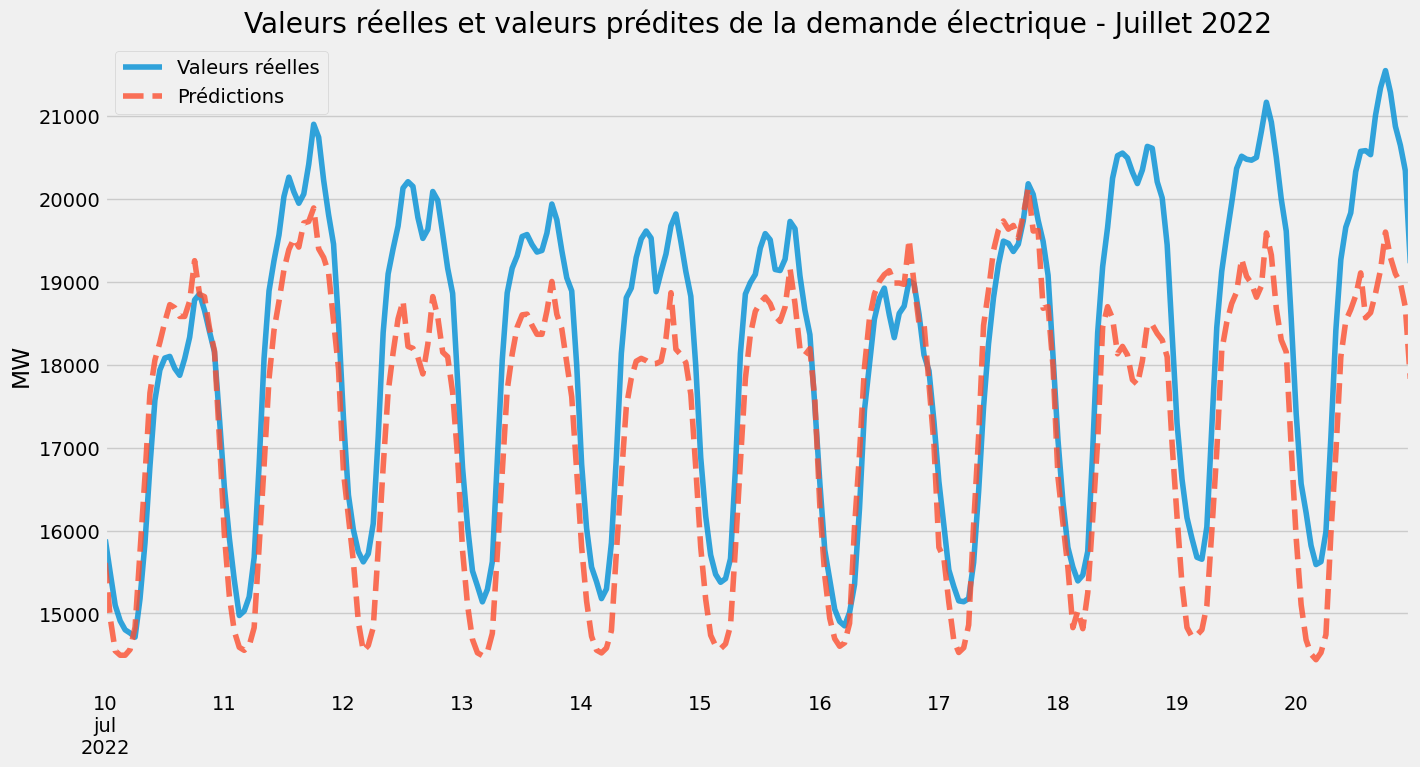

In [190]:
df_juin_2022 = df_pred["20220710":"20220720"]

ax = df_juin_2022.MW.plot(figsize=(15, 8), ylabel="MW", alpha=0.8)
df_juin_2022.prediction.plot(ax=ax, style="--", alpha=0.8, xlabel="")
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - Juillet 2022"
)

plt.show()

En été, les prédictions semblent sous-estimer la demande en creux et en sommet de la demande, même si la forme est très bien prédite (la double pointe).

### Évaluation des métriques

In [199]:
# RMSE
score_RMSE = np.sqrt(mean_squared_error(test.MW, test.prediction))
print(f"RMSE : {score_RMSE:0.2f}")

RMSE : 1576.00


In [200]:
# Erreurs : arreur absolue moyenne sur la journée
test["error"] = np.abs(test[TARGET] - test["prediction"])

In [205]:
test["jour"] = test.index.date

In [219]:
pire_journee = test.groupby("jour")["error"].mean().sort_values(ascending=False).head(5)
pire_journee

jour
2022-01-12    5911.056104
2022-01-27    4903.238649
2022-01-04    4811.152220
2022-01-05    4268.765098
2022-01-15    4116.055391
Name: error, dtype: float64

Les pires journées de prédiction sont durant le mois de janvier, quand les températures sont froides et que les pointes ne sont pas bien prédites par le modèle. 

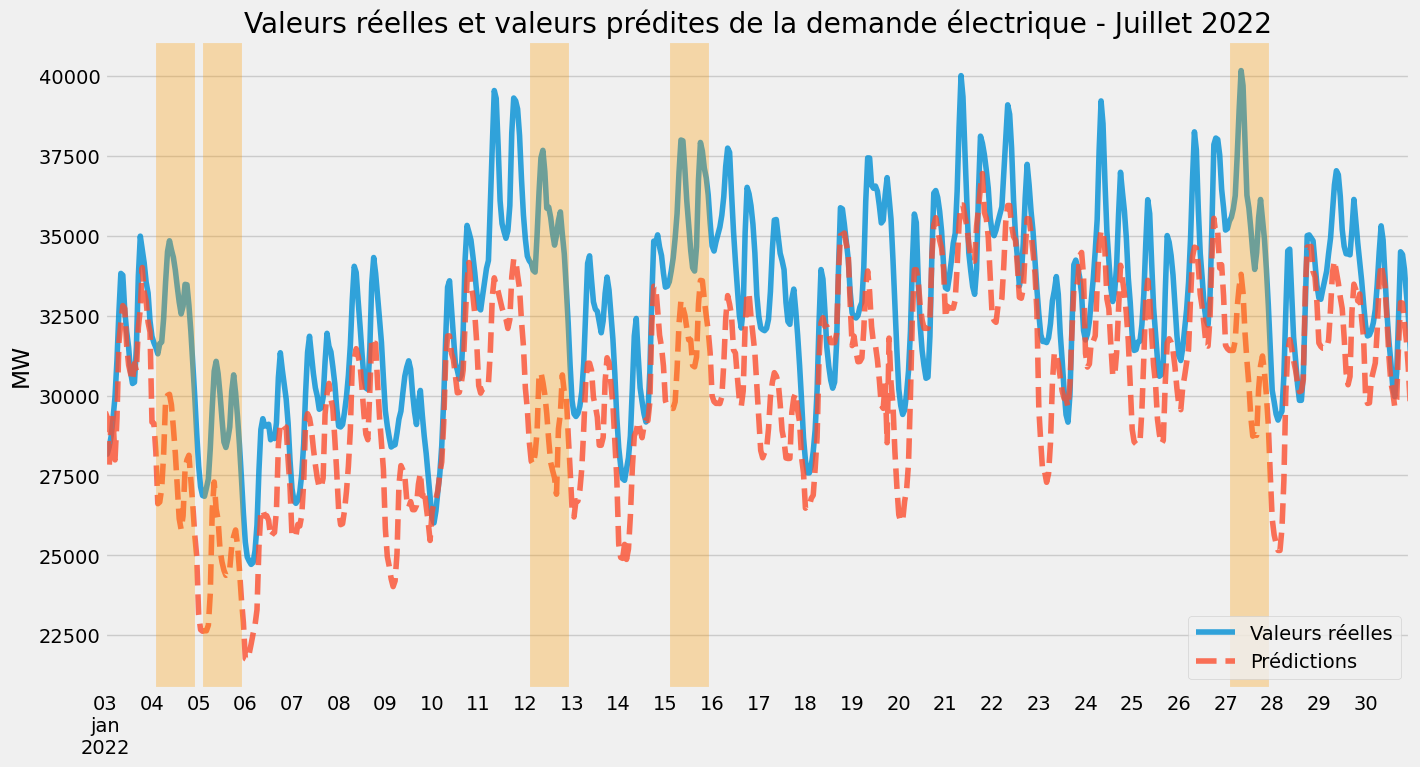

In [260]:
df_janv_2022 = df_pred["20220103":"20220130"]

ax = df_janv_2022.MW.plot(figsize=(15, 8), ylabel="MW", alpha=0.8)
df_janv_2022.prediction.plot(ax=ax, style="--", alpha=0.8, xlabel="")
plt.legend(["Valeurs réelles", "Prédictions"])

ax.set_title(
    "Valeurs réelles et valeurs prédites de la demande électrique - Juillet 2022"
)

for jour in pire_journee.index.to_list():
    ax.axvline(
        datetime(jour.year, jour.month, jour.day, 12, 0),
        color=colors_pal[11],
        linewidth=28,
        alpha=0.3,
    )

plt.show()

In [240]:
meilleure_journee = (
    test.groupby("jour")["error"].mean().sort_values(ascending=True).head(5)
)
meilleure_journee

jour
2022-05-01    235.759971
2022-06-25    254.084676
2022-10-16    270.456375
2022-10-26    289.359010
2022-09-25    299.622476
Name: error, dtype: float64

À première vue, les meilleures journées de prédiction semblent être en mi-saison (printemps, début été et automne). 

# Deuxième partie - renforcir le modèle

- [ ] Cross-validation
- [ ] Test plusieurs features
- [ ] Création de nouveaux features en fonction de ceux qui seront les meilleurs
- [ ] Tests paramètres XGBoost

## Inspiration

Part 2 : https://youtu.be/z3ZnOW-S550?si=VcoYQ4S5Zlcqffyr

## 1. Time Series Cross Validation

test_size = 1 an

In [ ]:
n_split = 4

tss = TimeSeriesSplit(n_splits=n_split, test_size=24*365*1, gap=24)
df = df.sort_index()

In [ ]:
fig, axs = plt.acorrsubplots(n_split,1, figsize=(15,5), share_x = True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train['MW']
    